In [1]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [2]:
# Please fill in your names here
NAME_STUDENT_1 = "Sander Ackermans"
NAME_STUDENT_2 = "Simon Karsten"

In [23]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

## MoneyBall (5 points, 1+2+1+1)
In the early 2000s, 2 baseball scouts completely changed the game of baseball by analysing the available data about baseball players and hiring the best ones.
The [MoneyBall dataset](https://www.openml.org/d/41021) contains this data (click the link for more details). The goal is to accurately predict the number of 'runs' each player can score. 

In [48]:
moneyball = oml.datasets.get_dataset(41021) # Download MoneyBall data
# Get the full data, as this makes it easier to plot all variables
data, attribute_names = moneyball.get_data(return_attribute_names=True)
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(data, columns=attribute_names)
ballframe.describe()

,Team,League,Year,RS,...,RankPlayoffs,G,OOBP,OSLG
count,1232.00,1232.0,1232.00,1232.00,...,244.00,1232.00,420.00,420.00
mean,15.67,0.5,1988.96,715.08,...,1.72,3.92,0.33,0.42
std,9.72,0.5,14.82,91.53,...,1.10,0.62,0.02,0.03
min,0.00,0.0,1962.00,463.00,...,0.00,0.00,0.29,0.35
25%,7.00,0.0,1976.75,652.00,...,1.00,4.00,0.32,0.40
50%,16.00,0.5,1989.00,711.00,...,2.00,4.00,0.33,0.42
75%,23.00,1.0,2002.00,775.00,...,3.00,4.00,0.34,0.44
max,38.00,1.0,2012.00,1009.00,...,4.00,7.00,0.38,0.50


1 . Visually explore the data. Plot the distribution of each feature (e.g. histograms), as well as the target. Visualize the dependency of the target on each feature (use a 2d scatter plot). Is there anything that stands out? Is there something that you think might require special treatment?
- Feel free to create additional plots that help you understand the data
- Only visualize the data, you don't need to change it (yet)

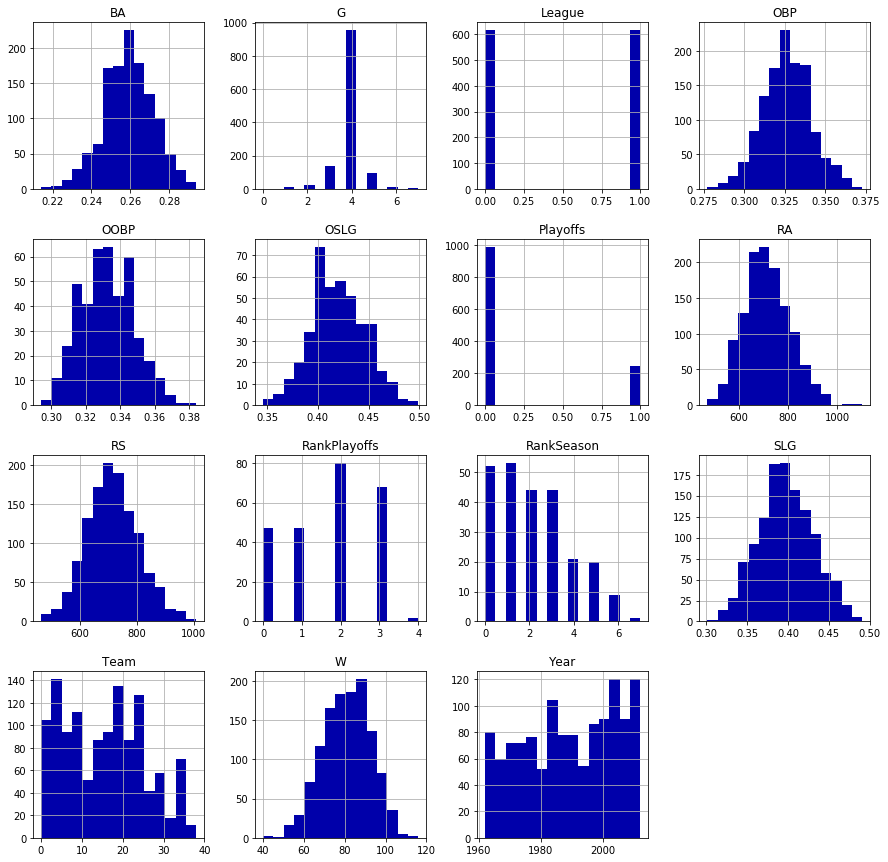

In [49]:
ballframe.hist(bins=15, figsize=[15,15]);

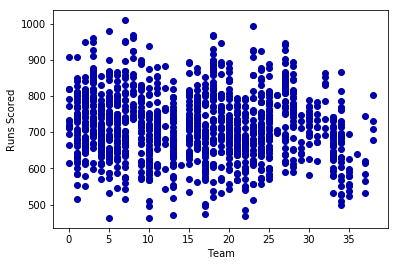

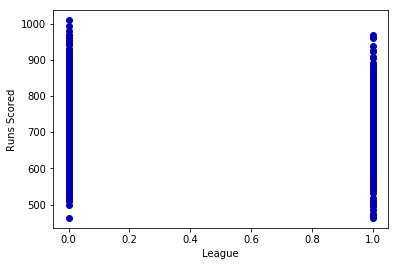

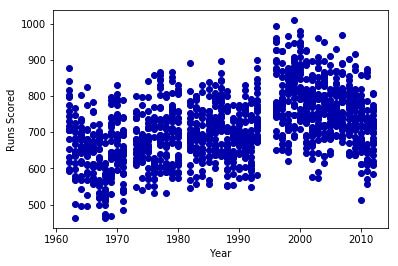

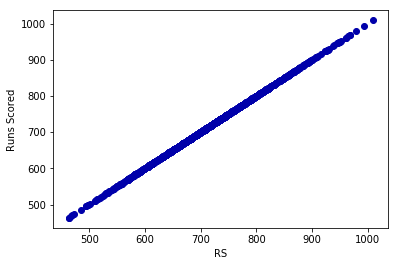

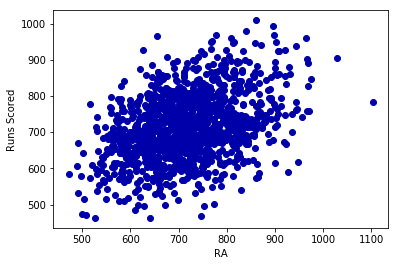

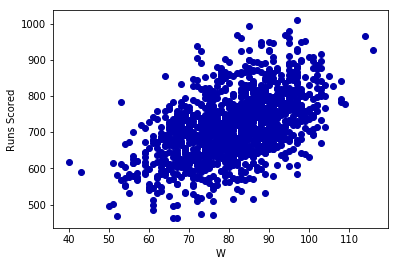

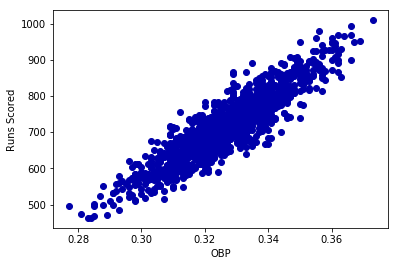

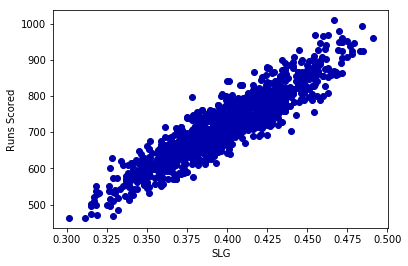

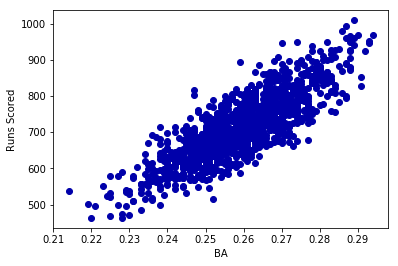

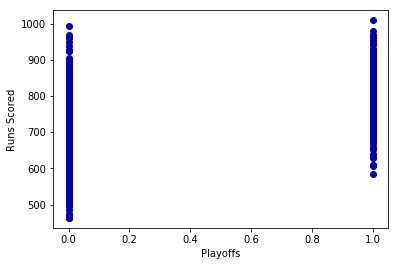

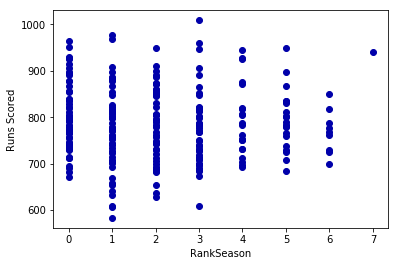

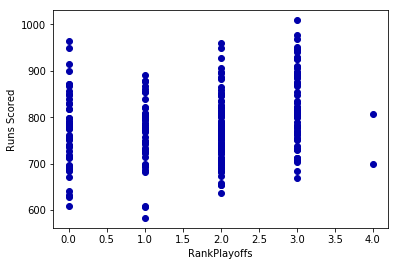

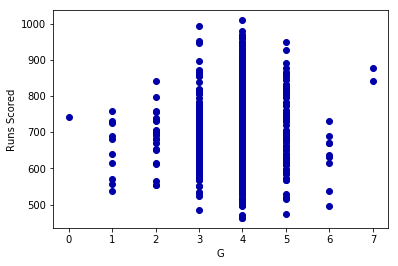

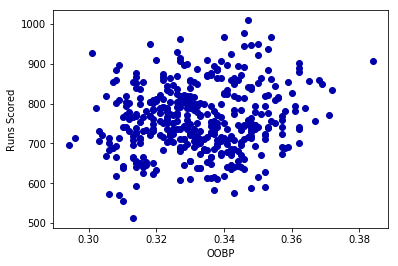

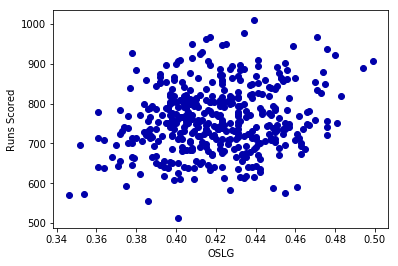

In [50]:
for i in range(15):
    plt.figure(i)
    plt.plot(attribute_names[i], "RS", data=ballframe, linestyle='none', marker='o')
    plt.xlabel(attribute_names[i])
    plt.ylabel("Runs Scored")

plt.show();

In [51]:
'''What stands out is the lack of variation in the variable G, as almost all of the teams have played 4 games.
When looking at the dependencies, a clear positive linear trend can be found for the variables RA, W, OBP, SLG and BA.
The relationship between Runs Scored and Wins, On-Base Percentage, Slugging Percentage and Batting Average seems easy to explain.
If you're more efficient and effective on bat, you are more likely to score runs. The more scored runs, the more likely you'll 
win the game.
The relationship between Runs Allowed and Runs Scored is more difficult to explain. Perhaps good offensive teams (e.g high
amount of runs scored) are poorer defensive teams and therefore allow more runs.
In any case, it seems that these 5 variables are most important in predicting RS.'''

"What stands out is the lack of variation in the variable G, as almost all of the teams have played 4 games.\nWhen looking at the dependencies, a clear positive linear trend can be found for the variables RA, W, OBP, SLG and BA.\nThe relationship between Runs Scored and Wins, On-Base Percentage, Slugging Percentage and Batting Average seems easy to explain.\nIf you're more efficient and effective on bat, you are more likely to score runs. The more scored runs, the more likely you'll \nwin the game.\nThe relationship between Runs Allowed and Runs Scored is more difficult to explain. Perhaps good offensive teams (e.g high\namount of runs scored) are poorer defensive teams and therefore allow more runs.\nIn any case, it seems that these 5 variables are most important in predicting RS."

2 . Compare all linear regression algorithms that we covered in class (Linear Regression, Ridge, Lasso and ElasticNet), as well as kNN. Evaluate using cross-validation and the $R^2$ score, with the default parameters. Does scaling the data with StandardScaler help? Provide a concise but meaningful interpretation of the results.
- Preprocess the data as needed (e.g. are there nominal features that are not ordinal?). If you don't know how to proceed, remove the feature and continue.

In [52]:
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

# Get the predictors x and the target y
X, y = moneyball.get_data(target=moneyball.default_target_attribute)

# a contains two categorical features that have NaN's, b contains two continuous features that have NaN's
a = X[:,9:11]
b = X[:,12:14]

# For the continuous features we use the mean, for the categorical we use most_frequent (to keep them categorical)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(b)
no_NaN_cont = imp.transform(b)
imp_fr = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_fr.fit(a)
no_NaN_cat = imp_fr.transform(a)

# Joining all categorical variables together and one hot encoding them so they can be used for the linear models
cat_vars = np.zeros((1232,5))
cat_vars[:,0] = X[:,0]
cat_vars[:,1] = X[:,2]
cat_vars[:,2] = X[:,11]
cat_vars[:,3:5] = no_NaN_cat
enc = OneHotEncoder()
enc.fit(cat_vars)
dummy_vars = enc.transform(cat_vars).toarray()

# Delete old features (categorical features and/or features containing NaN's)
X = np.delete(X, (0), axis=1)
X = np.delete(X, (1), axis=1)
X = np.delete(X, (7), axis=1)
X = np.delete(X, (7), axis=1)
X = np.delete(X, (7), axis=1)
X = np.delete(X, (7), axis=1)
X = np.delete(X, (7), axis=1)

# Add newly created features
X_new = np.zeros((1232,116))
X_new[:,0:7] = X
X_new[:,7:9] = no_NaN_cont
X_new[:,9:116] = dummy_vars


print("\nWith all features included:")
models = [("Linear Regression", LinearRegression()), ("Ridge", Ridge()), ("Lasso", Lasso()), ("ElasticNet", ElasticNet()), 
          ("kNN", KNeighborsRegressor())]
for modelname, model in models:
    score = cross_val_score(model, X_new, y, cv=10)
    pipe = Pipeline([("scaler", StandardScaler()), (modelname, model)])
    scaled_score = cross_val_score(pipe, X_new, y, cv=10)
    print("\n"+modelname+":\nOriginal: {}".format(score)+"\t\tMean:{:.2f}".format(score.mean())+
          "\nScaled: {}".format(scaled_score)+"\t\tMean:{:.2f}".format(scaled_score.mean()))
    

# Because I previously identified 5 variables as being most important, I want to create models with just these 5 as well
X = np.delete(X, (0), axis=1)
X = np.delete(X, (5), axis=1)

from sklearn.linear_model import ElasticNet

print("\n\n---------------------------------------\nWith only the 5 most important features included:")
for modelname, model in models:
    score = cross_val_score(model, X, y, cv=10)
    pipe = Pipeline([("scaler", StandardScaler()), (modelname, model)])
    scaled_score = cross_val_score(pipe, X, y, cv=10)
    print("\n"+modelname+":\nOriginal: {}".format(score)+"\t\tMean:{:.2f}".format(score.mean())+
          "\nScaled: {}".format(scaled_score)+"\t\tMean:{:.2f}".format(scaled_score.mean()))
print(); #to hide the unnecessary output


With all features included:

Linear Regression:
Original: [0.916 0.885 0.919 0.939 0.912 0.863 0.912 0.923 0.943 0.925]		Mean:0.91
Scaled: [-9.192e+24 -2.046e+24 -3.761e+24 -4.004e+25 -1.619e+25 -4.828e+25
 -6.106e+25 -1.890e+25 -2.979e+24 -9.848e+24]		Mean:-21229291094305732386881536.00

Ridge:
Original: [0.817 0.742 0.835 0.81  0.841 0.858 0.815 0.816 0.854 0.828]		Mean:0.82
Scaled: [0.917 0.886 0.92  0.94  0.912 0.863 0.912 0.923 0.943 0.925]		Mean:0.91

Lasso:
Original: [0.791 0.679 0.818 0.804 0.824 0.821 0.79  0.774 0.831 0.829]		Mean:0.80
Scaled: [0.919 0.887 0.923 0.933 0.906 0.912 0.913 0.925 0.945 0.931]		Mean:0.92

ElasticNet:
Original: [0.791 0.679 0.817 0.802 0.825 0.822 0.791 0.774 0.831 0.829]		Mean:0.80
Scaled: [0.885 0.831 0.861 0.823 0.838 0.859 0.85  0.849 0.869 0.889]		Mean:0.86

kNN:
Original: [0.775 0.54  0.692 0.568 0.808 0.799 0.791 0.686 0.653 0.711]		Mean:0.70
Scaled: [0.461 0.436 0.359 0.213 0.579 0.649 0.35  0.4   0.465 0.454]		Mean:0.44


-----------------

In [1]:
'''
In line with what I expected, the 5 features that seem to correlate most with the target are also the most important predictors.
In fact, every models scores either the same or higher when only including these 5 compared to including all features.
Furthermore, the results show that for the original, unscaled data the linear regression model generates the best results. 
However, scaling the data improves the results for the other 4 models when only including 5 features. Scaling 'evens the playing
field' so to speak, as all models show highly similar scores. However, with all the dummy variables included, linear regression
seems to overfit, leading to very bad test scores. Moreover, as all scores are around .9 or higher, we can safely conclude that 
these 5 features are good predictors of our target. I will therefore continue with only these 5 features, as this will reduce 
computing time and make interpretation of the results much easier.
'''

"\nIn line with what I expected, the 5 features that seem to correlate most with the target are also the most important predictors.\nIn fact, every models scores either the same or higher when only including these 5 compared to including all features.\nFurthermore, the results show that for the original, unscaled data the linear regression model generates the best results. \nHowever, scaling the data improves the results for the other 4 models when only including 5 features. Scaling 'evens the playing\nfield' so to speak, as all models show highly similar scores. However, with all the dummy variables included, linear regression\nseems to overfit, leading to very bad test scores. Moreover, as all scores are around .9 or higher, we can safely conclude that \nthese 5 features are good predictors of our target. I will therefore continue with only these 5 features, as this will reduce \ncomputing time and make interpretation of the results much easier.\n"

3 . Do a default, shuffled train-test split and optimize the linear models for the degree of regularization ($alpha$) and choice of penalty (L1/L2). For Ridge and  Lasso, plot a curve showing the effect of the training and test set performance ($R^2$) while increasing the degree of regularization for different penalties. For ElasticNet, plot a heatmap $alpha \times l1\_ratio \rightarrow R^2$ using test set performance.
Report the optimal performance. Again, provide a concise but meaningful interpretation. What does the regularization do? Can you get better results?
- Think about how you get the L1/L2 loss. This is not a hyperparameter in regression.
- We've seen how to generate such heatmaps in Lecture 3.

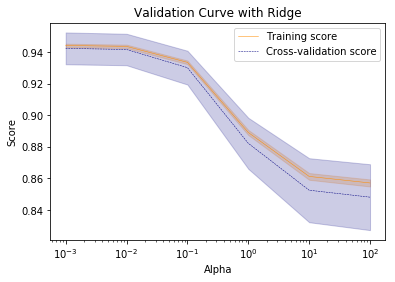

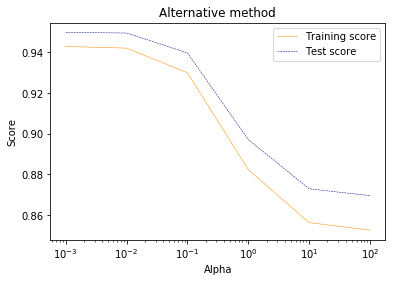

In [54]:
from sklearn.model_selection import validation_curve, ShuffleSplit, train_test_split

shuffle_split = ShuffleSplit()

# First a validation_curve
param_range = np.logspace(-3, 2, 6)
train_scores, test_scores = validation_curve(Ridge(), X, y, param_name="alpha", param_range=param_range, cv=shuffle_split)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
plt.legend(loc="best")
plt.show();


# Alternative method
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=0)

train_score = []
test_score = []
for i in param_range:
    ridge = Ridge(alpha=i).fit(X_train, y_train)
    train_score.append(ridge.score(X_train, y_train))
    test_score.append(ridge.score(X_test, y_test))

plt.semilogx(param_range, train_score, label="Training score", color="darkorange")
plt.semilogx(param_range, test_score, label="Test score", color="navy")
plt.title("Alternative method")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show();

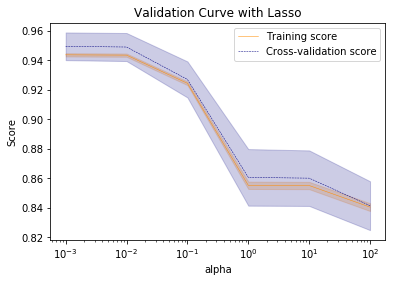

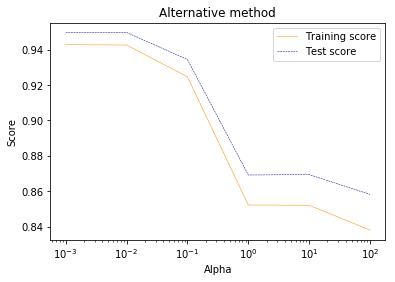

In [55]:
# First a validation_curve
param_range = np.logspace(-3, 2, 6)
train_scores, test_scores = validation_curve(Lasso(), X, y, param_name="alpha", param_range=param_range, cv=shuffle_split)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Lasso")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
plt.legend(loc="best")
plt.show();


# Alternative method
train_score = []
test_score = []
for i in param_range:
    lasso = Lasso(alpha=i).fit(X_train, y_train)
    train_score.append(lasso.score(X_train, y_train))
    test_score.append(lasso.score(X_test, y_test))

plt.semilogx(param_range, train_score, label="Training score", color="darkorange")
plt.semilogx(param_range, test_score, label="Test score", color="navy")
plt.title("Alternative method")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show();

Test set score: 0.95
Best parameters: {'alpha': 0, 'l1_ratio': 0}
Best cross-validation score: 0.94


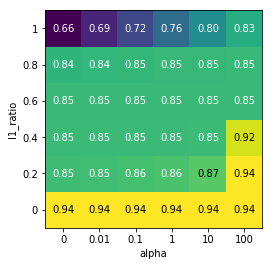

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

param_grid = {'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1], 'alpha': [0, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='alpha', xticklabels=param_grid['alpha'],
                      ylabel='l1_ratio', yticklabels=param_grid['l1_ratio'], cmap="viridis");

In [57]:
'''It is clear that optimal performance is achieved when there is no regularization whatsoever (e.g. L1 = 0 and L2 = 0).
This means that the best result is generated by using a simple linear regression. What regularization does is restrict the
model to avoid overfitting. Increasing the alpha forces coefficients to move more toward zero. A reason to use regularization
is that it may have a positive effect on test scores, even when training scores may decrease slightly. However, in our case
test scores and training scores both decrease, meaning optimal performance is achieved when no regularization is applied.'''

'It is clear that optimal performance is achieved when there is no regularization whatsoever (e.g. L1 = 0 and L2 = 0).\nThis means that the best result is generated by using a simple linear regression. What regularization does is restrict the\nmodel to avoid overfitting. Increasing the alpha forces coefficients to move more toward zero. A reason to use regularization\nis that it may have a positive effect on test scores, even when training scores may decrease slightly. However, in our case\ntest scores and training scores both decrease, meaning optimal performance is achieved when no regularization is applied.'

4 . Visualize the coefficients of the optimized models. Do they agree on which features are
important? Compare the results with the feature importances returned by a RandomForest. Does it agree with the linear models? What would look for when scouting for a baseball player?

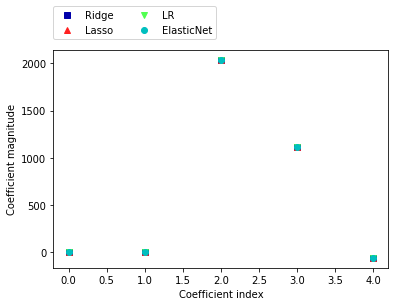


-----------------
RandomForest feature importances: [0.016 0.02  0.3   0.653 0.012]


In [58]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)
lasso = Lasso(alpha=0, max_iter=100000).fit(X_train, y_train)
ridge = Ridge(alpha=0).fit(X_train, y_train)
lr = LinearRegression().fit(X_train, y_train)
ElasticNet = ElasticNet(alpha=0, l1_ratio=0).fit(X_train, y_train)

plt.plot(ridge.coef_, 's', label="Ridge")
plt.plot(lasso.coef_, '^', label="Lasso")
plt.plot(lr.coef_, 'v', label="LR")
plt.plot(ElasticNet.coef_, 'o', label="ElasticNet")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend(ncol=2, loc=(0, 1.05))
plt.show()

print("\n-----------------\nRandomForest feature importances: {}".format(rf.feature_importances_));

In [59]:
'''
Because the optimal parameters for all models were in fact 0, all models return exactly the same coeficients. This means they
do indeed agree on which features are important. Specifically, the feature at index 2 is most important, then the feature at
index 3, with the other 3 being far less important. These features represent On-Base Percentage (OBP) and Slugging Percentage
SLG), with OBP being most important. The RandomForest regressor identifies the same 2 features as important, but in reversed
order. According to the rf model, SLG is most important. In any case, if I was a baseball scout, I would be looking for players 
with a high OBP and SLG as these will help my team score the most runs.
'''

'\nBecause the optimal parameters for all models were in fact 0, all models return exactly the same coeficients. This means they\ndo indeed agree on which features are important. Specifically, the feature at index 2 is most important, then the feature at\nindex 3, with the other 3 being far less important. These features represent On-Base Percentage (OBP) and Slugging Percentage\nSLG), with OBP being most important. The RandomForest regressor identifies the same 2 features as important, but in reversed\norder. According to the rf model, SLG is most important. In any case, if I was a baseball scout, I would be looking for players \nwith a high OBP and SLG as these will help my team score the most runs.\n'

## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [ ]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

In [ ]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();

1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [5]:
# Get the data
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

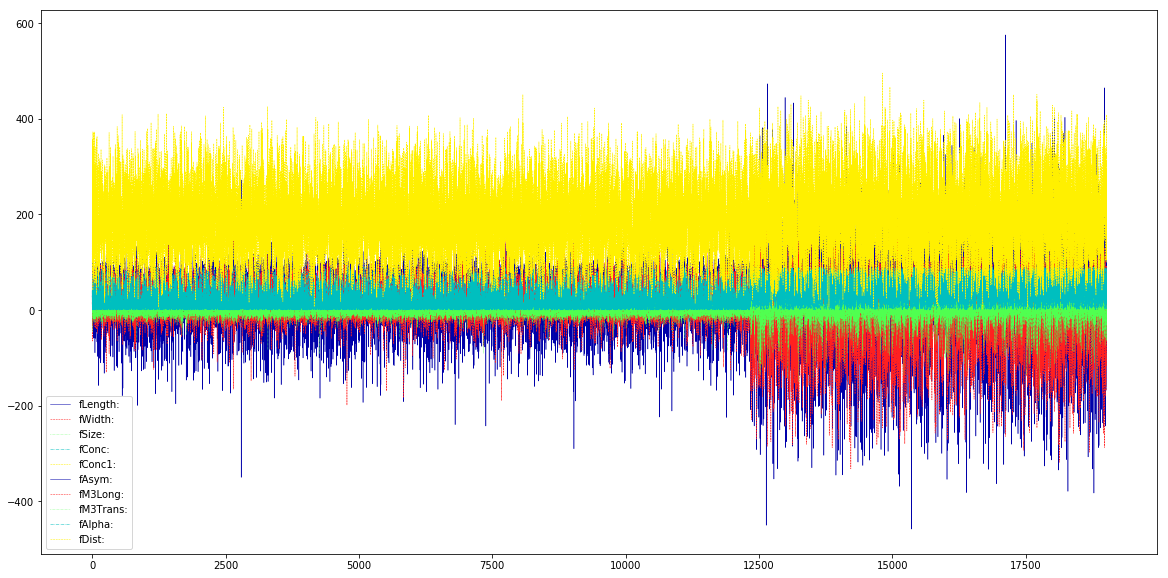

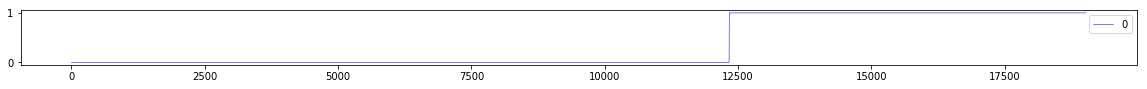

In [6]:
# Quick visualization
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

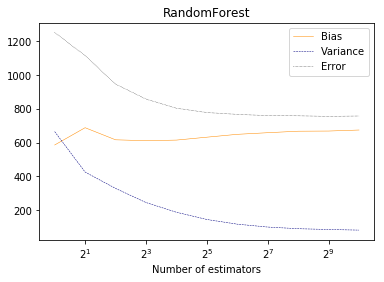

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Bootstraps
n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

bias_sq = []
var = []
error = []
param_range = np.logspace(0, 10, num=11, base=2, dtype=int)

for i in param_range:
    model = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=0)
    
    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]
    
    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        model.fit(X[train_index], y[train_index])
        y_pred = model.predict(X[test_index])
    
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])
            
    # Compute bias, variance, error
    bias_sq.append(sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                        for i,x in enumerate(y_all_pred)]))
    var.append(sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat 
                    for i,x in enumerate(y_all_pred)]))
    error.append(sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                      for i,x in enumerate(y_all_pred)]))


plt.semilogx(param_range, bias_sq, label="Bias", color="darkorange")
plt.semilogx(param_range, var, label="Variance", color="navy")
plt.semilogx(param_range, error, label="Error", color="black")
plt.semilogx(basex=2)
plt.title("RandomForest")
plt.xlabel("Number of estimators")
plt.legend(loc="best")
plt.show();

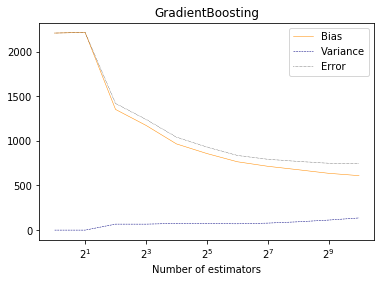

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

bias_sq = []
var = []
error = []

for i in param_range:
    model = GradientBoostingClassifier(n_estimators=i, random_state=0)
    
    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]
    
    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        model.fit(X[train_index], y[train_index])
        y_pred = model.predict(X[test_index])
    
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])
            
    # Compute bias, variance, error
    bias_sq.append(sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                        for i,x in enumerate(y_all_pred)]))
    var.append(sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat 
                    for i,x in enumerate(y_all_pred)]))
    error.append(sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                      for i,x in enumerate(y_all_pred)]))


plt.semilogx(param_range, bias_sq, label="Bias", color="darkorange")
plt.semilogx(param_range, var, label="Variance", color="navy")
plt.semilogx(param_range, error, label="Error", color="black")
plt.semilogx(basex=2)
plt.title("GradientBoosting")
plt.xlabel("Number of estimators")
plt.legend(loc="best")
plt.show();

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

Best iteration at learning rate (0.1) and depth (1) = 499 
Test score: 0.10

Best iteration at learning rate (0.1) and depth (4) = 491 
Test score: 0.07

Best iteration at learning rate (1.0) and depth (1) = 321 
Test score: 0.10

Best iteration at learning rate (1.0) and depth (4) = 491 
Test score: 0.09



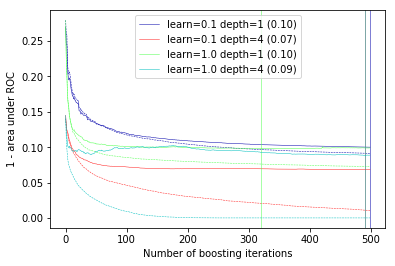

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        print("Best iteration at learning rate (%.1f) and depth (%i) = %i \nTest score: %.2f\n"%(learn,depth,
                                                                                          best_iter, test_score[best_iter]))
        test_line = plt.plot(test_score, '-',
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')
    

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gc_one = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1).fit(X_train, y_train)
gc_two = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=4).fit(X_train, y_train)
gc_three = GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=1).fit(X_train, y_train)
gc_four = GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=4).fit(X_train, y_train)
clfs = [gc_one, gc_two, gc_three, gc_four]

validation_curve(clfs, X_test, y_test, X_train, y_train)